## Загрузка зависимостей

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

## Загрузка датасета

In [2]:
# загрузка датасета
df = pd.read_csv("heart_attack_prediction_dataset.csv")

In [ ]:
df.info()

In [ ]:
# количество уникальных значений
df.nunique()

## Чистка и проверка

In [3]:
# удаляем столбец id пациентов
df = df.drop("Patient ID", axis=1)

In [4]:
# разделим Blood Pressure на две колонки Systolic и Diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'] \
    .str.replace('"', '') \
    .str.split('/', expand=True)

# Преобразуем новые столбцы в числовой тип данных
df['Systolic'] = pd.to_numeric(df['Systolic'], errors='coerce')
df['Diastolic'] = pd.to_numeric(df['Diastolic'], errors='coerce')

# Вывод итогового DataFrame с новыми столбцами
print("датасет с разделёнными столбцами (Systolic и Diastolic):")
print(df.head())

датасет с разделёнными столбцами (Systolic и Diastolic):
   Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0   67    Male          208         158/88          72         0   
1   21    Male          389         165/93          98         1   
2   21  Female          324         174/99          72         1   
3   84    Male          383        163/100          73         1   
4   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  Alcohol Consumption  ...        BMI  \
0               0        1        0                    0  ...  31.251233   
1               1        1        1                    1  ...  27.194973   
2               0        0        0                    0  ...  28.176571   
3               1        1        0                    1  ...  36.464704   
4               1        1        1                    0  ...  21.809144   

  Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0   

In [5]:
# удалим давление крови
df = df.drop("Blood Pressure", axis=1)

In [6]:
#удаляем так же Страну, Полушарие
df = df.drop("Country", axis=1)
df = df.drop("Continent", axis=1)

In [ ]:
# проверка на дубликаты
df.drop_duplicates()

In [ ]:
# проверка на пустые значения
df.isnull()

## Кодируем категориальные данные

In [7]:
# кодируем категориальные параметры
sex = LabelEncoder()
diet = LabelEncoder()
hemisphere = LabelEncoder()

df['Sex'] = sex.fit_transform(df['Sex'])
df['Diet'] = diet.fit_transform(df['Diet'])
df['Hemisphere'] = hemisphere.fit_transform(df['Hemisphere'])

In [8]:
print("\nКодирование для Sex:")
for code, label in enumerate(sex.classes_):
    print(f"{label}: {code}")

print("\nКодирование для Diet:")
for code, label in enumerate(diet.classes_):
    print(f"{label}: {code}")

print("\nКодирование для Hemisphere:")
for code, label in enumerate(hemisphere.classes_):
    print(f"{label}: {code}")


Кодирование для Sex:
Female: 0
Male: 1

Кодирование для Diet:
Average: 0
Healthy: 1
Unhealthy: 2

Кодирование для Hemisphere:
Northern Hemisphere: 0
Southern Hemisphere: 1


## Анализ

In [ ]:
# сравнение двух признаков
def compare_two_feature(attr_one, attr_two, dataframe):
    risk_by_attr = dataframe.groupby([attr_one, attr_two]).size().unstack(fill_value=0)
    risk_by_attr_percentage = risk_by_attr.div(risk_by_attr.sum(axis=1), axis=0) * 100
    risk_by_attr_percentage = risk_by_attr_percentage.applymap(lambda x: f"{x:.2f}%")
    print(risk_by_attr_percentage)

In [ ]:
# Age распределение
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=False, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Age и Heart Attack Risk
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='Age', hue='Heart Attack Risk', palette='deep')
plt.title('Age vs Heart Attack Risk')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()


In [ ]:
# выведем отношение у каждой категории возраста где риск больше 40%
risk_by_age = df.groupby(['Age', 'Heart Attack Risk']).size().unstack(fill_value=0)
risk_by_age_percentage = risk_by_age.div(risk_by_age.sum(axis=1), axis=0) * 100
risk_by_age_percentage = risk_by_age_percentage.applymap(lambda x: f"{x:.2f}%")
filtered_result = risk_by_age_percentage[risk_by_age_percentage[1].str.rstrip('%').astype(float) > 40]
pd.set_option('display.max_rows', None)
print(filtered_result)

pd.reset_option('display.max_rows')

In [ ]:
# Распределение Cholesterol
plt.figure(figsize=(8, 6))
sns.histplot(df['Cholesterol'], kde=False, bins=20)
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Cholesterol и Heart Attack
sns.histplot(data=df, x='Cholesterol', hue='Heart Attack Risk', kde=True, palette='deep', bins=30)

In [ ]:
# систолическое давление
plt.figure(figsize=(8, 6))
sns.histplot(df['Systolic'], kde=False, bins=20)
plt.title('Systolic Distribution')
plt.xlabel('Systolic')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#диастолическое давление
plt.figure(figsize=(8, 6))
sns.histplot(df['Diastolic'], kde=False, bins=20)
plt.title('Diastolic Distribution')
plt.xlabel('Diastolic')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# распределение кровяного давления
ratio = df['Systolic'] / df['Diastolic']

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Heart Attack Risk', y=ratio, palette='deep')

plt.title('Ratio by Heart Attack Risk')
plt.xlabel('Heart Attack Risk')
plt.ylabel('Ratio')
plt.show()

In [ ]:
attrs = ['Sex', 'Diabetes', 'Smoking', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level']

for a in attrs:
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x=a, hue='Heart Attack Risk', palette='deep')
    plt.title(a + ' vs Heart Attack Risk')
    plt.xlabel(a)
    plt.ylabel('Count')
    plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
    plt.show()

In [ ]:
# количество в процентах каждого признака в сравнениях
for attr in attrs:
    compare_two_feature(attr, 'Heart Attack Risk', df)
    print('')

## Распределение фич

In [ ]:
df.describe()

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Построение гистограмм для каждого числового столбца
for column in numeric_columns:
    plt.figure(figsize=(4,3))
    plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

In [ ]:
from scipy.stats import shapiro

for column in numeric_columns:
    stat, p = shapiro(df[column].dropna())
    print(f'{column}: stat={stat:.3f}, p={p:.3f}')
    if p > 0.05:
        print(f'{column} распределён нормально (не отвергаем H0)')
    else:
        print(f'{column} распределён не нормально (отвергаем H0)')


In [ ]:
from scipy.stats import kstest, norm

for column in numeric_columns:
    col_data = df[column].dropna()
    # Нормируем данные (для сравнения с нормальным распределением)
    standardized_data = (col_data - col_data.mean()) / col_data.std()
    stat, p = kstest(standardized_data, 'norm')
    print(f'{column}: stat={stat:.3f}, p={p:.3f}')
    if p > 0.05:
        print(f'{column} распределён нормально (не отвергаем H0)')
    else:
        print(f'{column} распределён не нормально (отвергаем H0)')

## Проверка выборосов

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Проверка на выбросы с использованием IQR
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    if outliers.empty:
        print(f"Нет выбросов в {column}")
    else:
        print(f"Есть выбросы в {column}:")
        print(outliers[[column]])

In [ ]:
# Получите все числовые столбцы
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Проверка на выбросы с использованием Z-оценки
for column in numeric_columns:
    mean = np.mean(df[column])
    std_dev = np.std(df[column])

    threshold = 3
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    if outliers.empty:
        print(f"Нет выбросов в {column}")
    else:
        print(f"Есть выбросы в {column}:")
        print(outliers[[column]])

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Вычисление корреляционной матрицы
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Добавление заголовка
plt.title('Тепловая карта корреляции')

# Показать график
plt.show()

In [ ]:
correlation_with_success = correlation_matrix['Heart Attack Risk']

# Sort the correlation values in descending order
correlation_ranked = correlation_with_success.sort_values(ascending=False)

# Print the ranked correlation values
print(correlation_ranked)

# Обучение

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [12]:
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Проверка размеров выборок
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

accuracy = model.score(X_test, y_test)
print(f"Точность модели на выбранных признаках: {accuracy:.2f}")

Размер обучающей выборки: 7010
Размер тестовой выборки: 1753
Точность модели на выбранных признаках: 0.64


/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Создание модели
model = LogisticRegression(max_iter=1000)

# Создание объекта RFE
rfe = RFE(estimator=model, n_features_to_select=5)  # Выбираем 10 наиболее важных признаков

# Обучение RFE
rfe.fit(X_train, y_train)

# Получение выбранных признаков
selected_features = X.columns[rfe.support_]
print("Выбранные признаки:")
print(selected_features)

# Оценка модели на выбранных признаках
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Обучение модели на выбранных признаках
model.fit(X_train_rfe, y_train)

# Оценка модели
accuracy = model.score(X_test_rfe, y_test)
print(f"Точность модели на выбранных признаках: {accuracy:.2f}")

/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Выбранные признаки:
Index(['Diabetes', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Hemisphere'], dtype='object')
Точность модели на выбранных признаках: 0.64


In [21]:
y_train_series = pd.Series(y_train)

# Calculate the class distribution in the training data
class_dist_train = y_train_series.value_counts()
print("Class distribution in training data:")
print(class_dist_train)
print()

# Calculate the percentage for each class in the training data
total_samples_train = class_dist_train.sum()
percentages_train = (class_dist_train / total_samples_train) * 100
print("Class Percentages in Training Data:")
print(percentages_train)

Class distribution in training data:
Heart Attack Risk
0    4499
1    2511
Name: count, dtype: int64

Class Percentages in Training Data:
Heart Attack Risk
0    64.179743
1    35.820257
Name: count, dtype: float64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Применение SMOTE для увеличения выборки
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Проверка размеров выборок после SMOTE
print(f'Размер обучающей выборки до SMOTE: {X_train.shape[0]}')
print(f'Размер обучающей выборки после SMOTE: {X_train_resampled.shape[0]}')

# Обучение модели на увеличенной выборке
model.fit(X_train_resampled, y_train_resampled)

# Оценка модели
accuracy = model.score(X_test, y_test)
print(f"Точность модели на тестовой выборке: {accuracy:.2f}")

Размер обучающей выборки до SMOTE: 7010
Размер обучающей выборки после SMOTE: 8998
Точность модели на тестовой выборке: 0.51


/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:


# Применение SMOTE для увеличения выборки
smote = SMOTE(random_state=42)
X_train_resampled_rfe, y_train_resampled_rfe = smote.fit_resample(X_train_rfe, y_train)

# Проверка размеров выборок после SMOTE
print(f'Размер обучающей выборки до SMOTE: {X_train_rfe.shape[0]}')
print(f'Размер обучающей выборки после SMOTE: {X_train_resampled_rfe.shape[0]}')

# Обучение модели на увеличенной выборке
model.fit(X_train_resampled_rfe, y_train_resampled_rfe)

# Оценка модели
accuracy = model.score(X_test_rfe, y_test)
print(f"Точность модели на тестовой выборке: {accuracy:.2f}")

Размер обучающей выборки до SMOTE: 7010
Размер обучающей выборки после SMOTE: 8998
Точность модели на тестовой выборке: 0.47


## Подбор параметров

Оптимальное значение k: 20


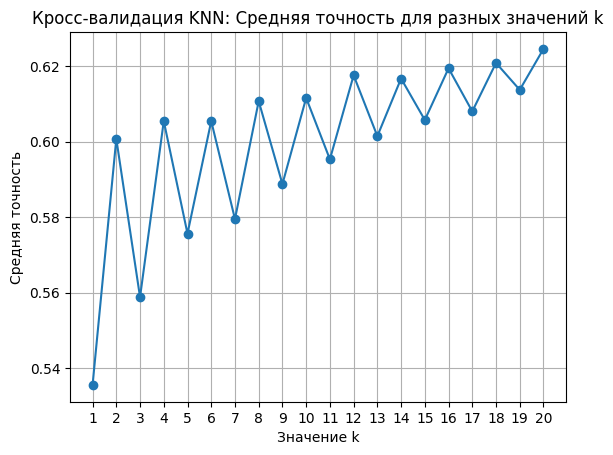

In [30]:
# Список значений k для тестирования
k_values = range(1, 21)  # От 1 до 20

# Список для хранения средних значений точности
mean_scores = []

# Кросс-валидация для каждого k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # 5-кратная кросс-валидация
    mean_scores.append(scores.mean())

# Поиск оптимального k
optimal_k = k_values[np.argmax(mean_scores)]
print(f"Оптимальное значение k: {optimal_k}")

# Визуализация результатов
import matplotlib.pyplot as plt

plt.plot(k_values, mean_scores, marker='o')
plt.title('Кросс-валидация KNN: Средняя точность для разных значений k')
plt.xlabel('Значение k')
plt.ylabel('Средняя точность')
plt.xticks(k_values)
plt.grid()
plt.show()

Оптимальное значение k: 16


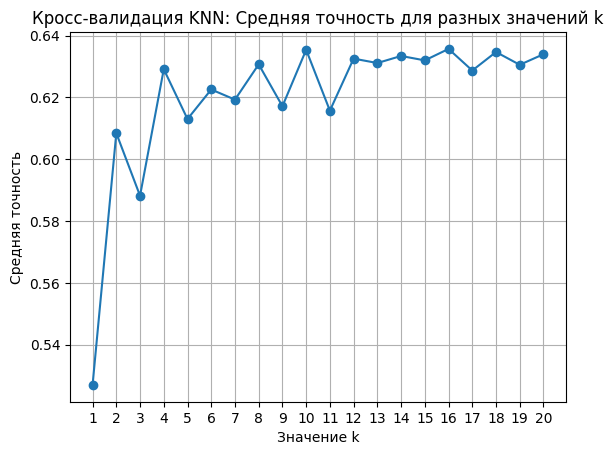

In [41]:
# Список значений k для тестирования
k_values = range(1, 21)  # От 1 до 20

# Список для хранения средних значений точности
mean_scores = []

# Кросс-валидация для каждого k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_rfe, y_train, cv=5)  # 5-кратная кросс-валидация
    mean_scores.append(scores.mean())

# Поиск оптимального k
optimal_k = k_values[np.argmax(mean_scores)]
print(f"Оптимальное значение k: {optimal_k}")

# Визуализация результатов
import matplotlib.pyplot as plt

plt.plot(k_values, mean_scores, marker='o')
plt.title('Кросс-валидация KNN: Средняя точность для разных значений k')
plt.xlabel('Значение k')
plt.ylabel('Средняя точность')
plt.xticks(k_values)
plt.grid()
plt.show()

In [46]:
# Определение модели
gbc = GradientBoostingClassifier()

# Определение параметров для подбора
param_grid = {
    'n_estimators': [50, 100, 150],  # Количество деревьев
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
    'max_depth': [3, 5, 7],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения
}

# Настройка Grid Search
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и их точности
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность: {grid_search.best_score_:.4f}")

# Оценка на тестовой выборке
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая точность: 0.6424
Точность на тестовой выборке: 0.6429


## Обучение и сравнение

Logistic Regression: Accuracy: 0.642
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

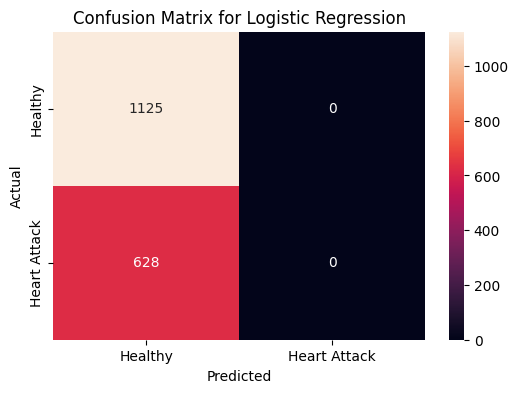

KNN: Accuracy: 0.619
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.64      0.93      0.76      1125
           1       0.32      0.06      0.10       628

    accuracy                           0.62      1753
   macro avg       0.48      0.49      0.43      1753
weighted avg       0.53      0.62      0.52      1753




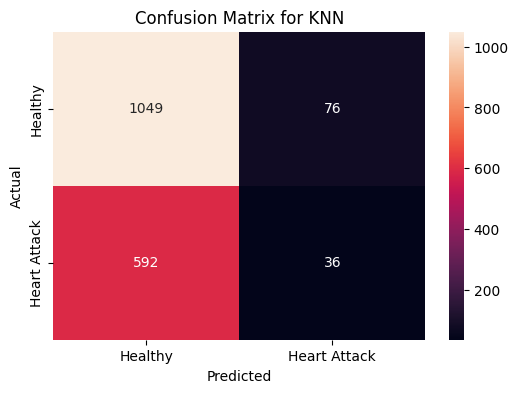

Decision Tree: Accuracy: 0.556
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.66      0.63      0.65      1125
           1       0.39      0.42      0.40       628

    accuracy                           0.56      1753
   macro avg       0.52      0.53      0.52      1753
weighted avg       0.56      0.56      0.56      1753




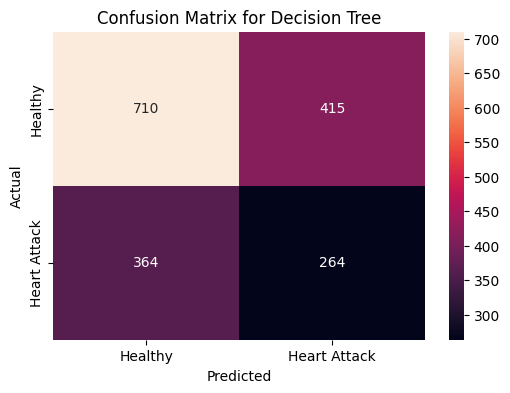

Naive Bayes: Accuracy: 0.642
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

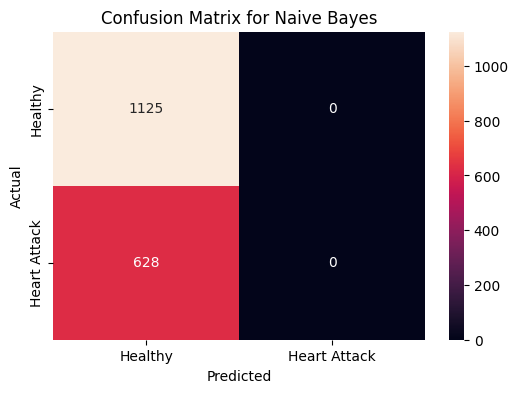

Support Vector Machine: Accuracy: 0.642
Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

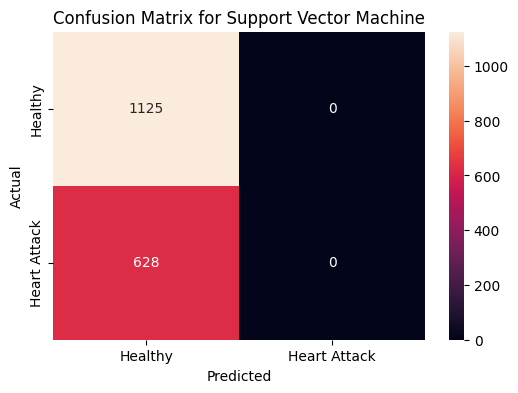

GBM: Accuracy: 0.643
Classification Report for GBM:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       1.00      0.00      0.01       628

    accuracy                           0.64      1753
   macro avg       0.82      0.50      0.39      1753
weighted avg       0.77      0.64      0.50      1753




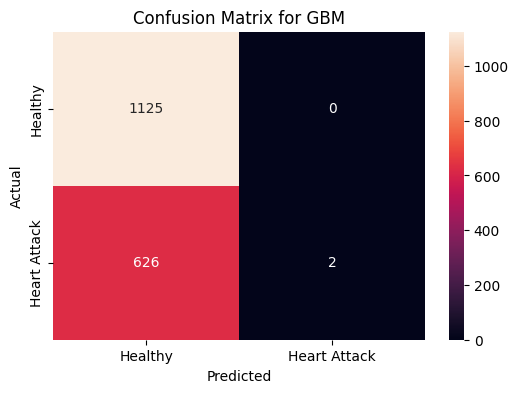

XGBoost: Accuracy: 0.588
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.64      0.81      0.72      1125
           1       0.36      0.19      0.25       628

    accuracy                           0.59      1753
   macro avg       0.50      0.50      0.48      1753
weighted avg       0.54      0.59      0.55      1753




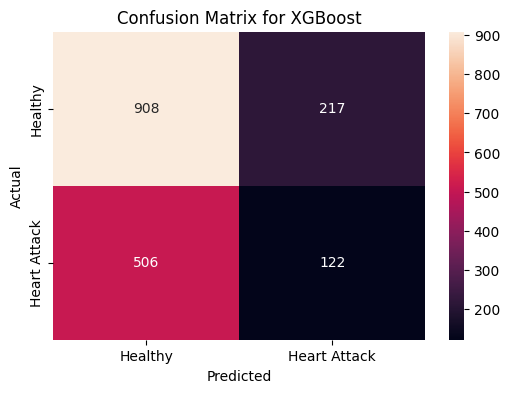

/tmp/ipykernel_8886/1515581975.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=results, palette='viridis')


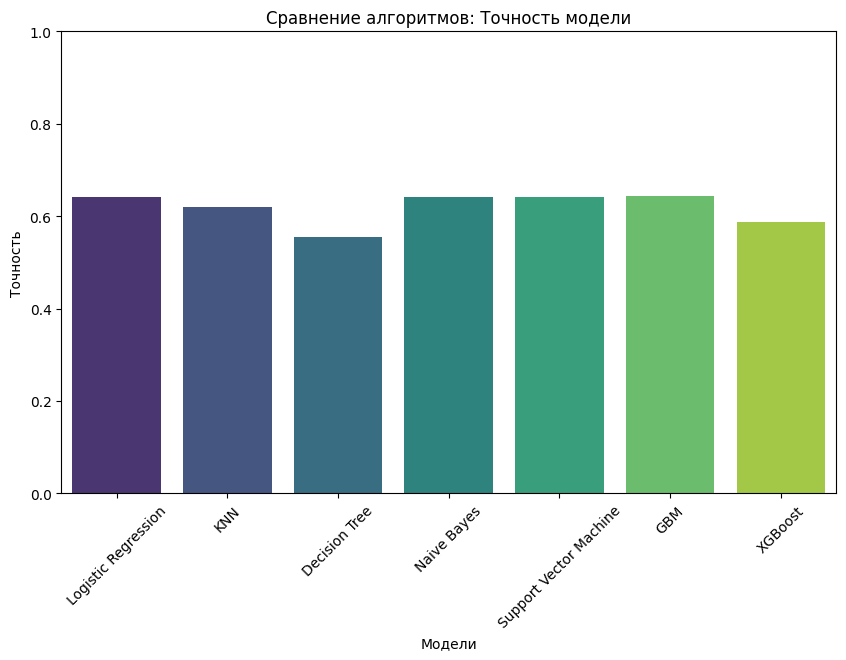

In [47]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier(n_neighbors=20)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Support Vector Machine', SVC()),
    ('GBM', GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100)),
    ('XGBoost', xgb.XGBClassifier(eval_metric='mlogloss'))
]

# Prepare lists to store results and names
results = []
names = []

# Evaluate each model in turn
for name, model in models:
    # Train the model using training data (SMOTE for handling imbalance)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Accuracy score
    accuracy = model.score(X_test, y_test)
    results.append(accuracy)
    names.append(name)
    print(f"{name}: Accuracy: {accuracy:.3f}")
    
    # Classification report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=['Healthy', 'Heart Attack'], 
                yticklabels=['Healthy', 'Heart Attack'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Bar plot for algorithm comparison (accuracies of models)
plt.figure(figsize=(10, 6))
sns.barplot(x=names, y=results, palette='viridis')
plt.title('Сравнение алгоритмов: Точность модели')
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.ylim(0, 1)  # Limiting y-axis from 0 to 1 for accuracy percentage
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()

Logistic Regression: Accuracy: 0.642
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

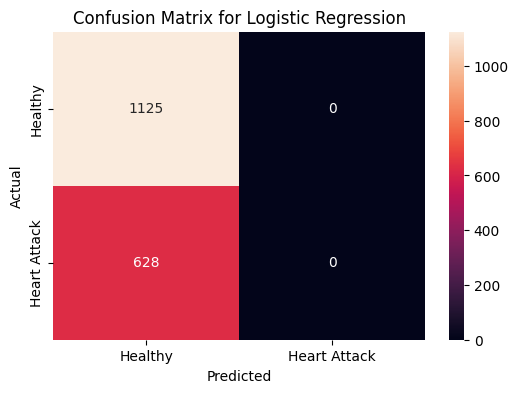

KNN: Accuracy: 0.639
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.64      0.98      0.78      1125
           1       0.45      0.03      0.06       628

    accuracy                           0.64      1753
   macro avg       0.55      0.51      0.42      1753
weighted avg       0.57      0.64      0.52      1753




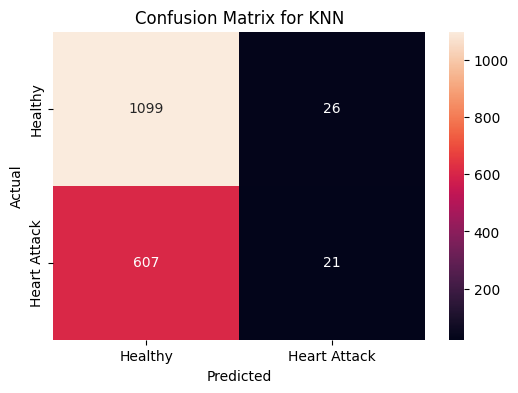

Decision Tree: Accuracy: 0.642
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

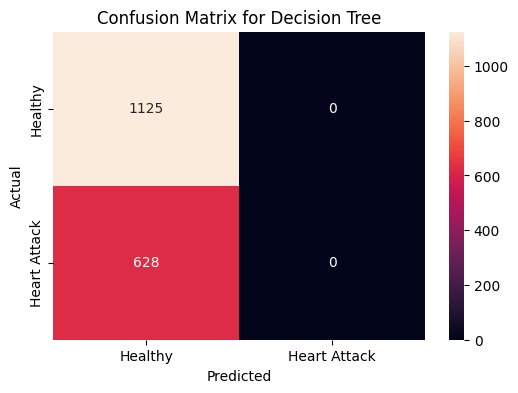

Naive Bayes: Accuracy: 0.642
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

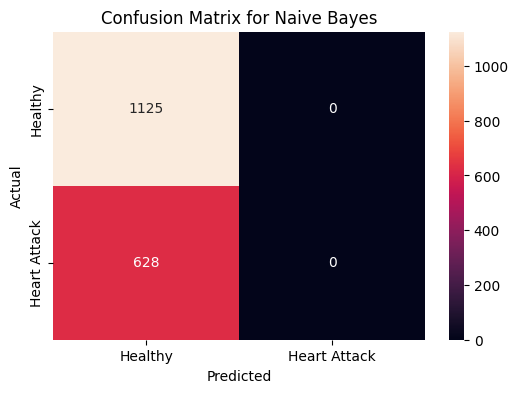

Support Vector Machine: Accuracy: 0.642
Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

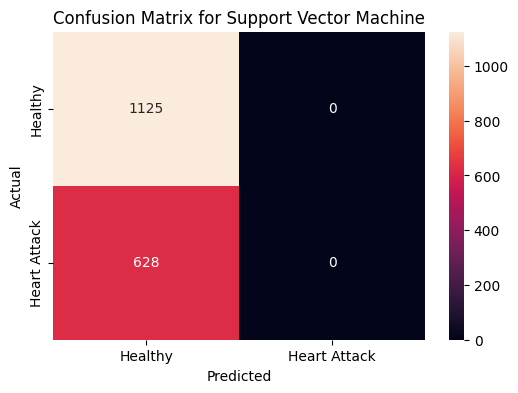

GBM: Accuracy: 0.642
Classification Report for GBM:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

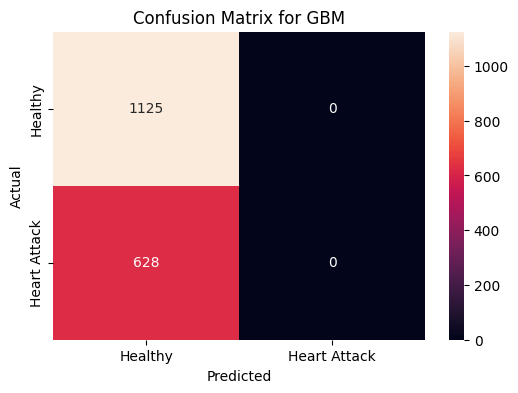

XGBoost: Accuracy: 0.642
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753




/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ml/Jupyter/notebookenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

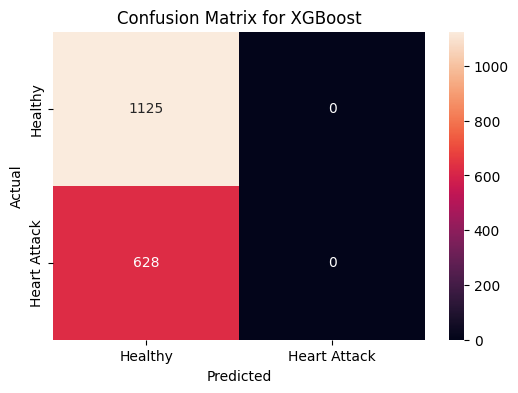

/tmp/ipykernel_8886/3821844486.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=results, palette='viridis')


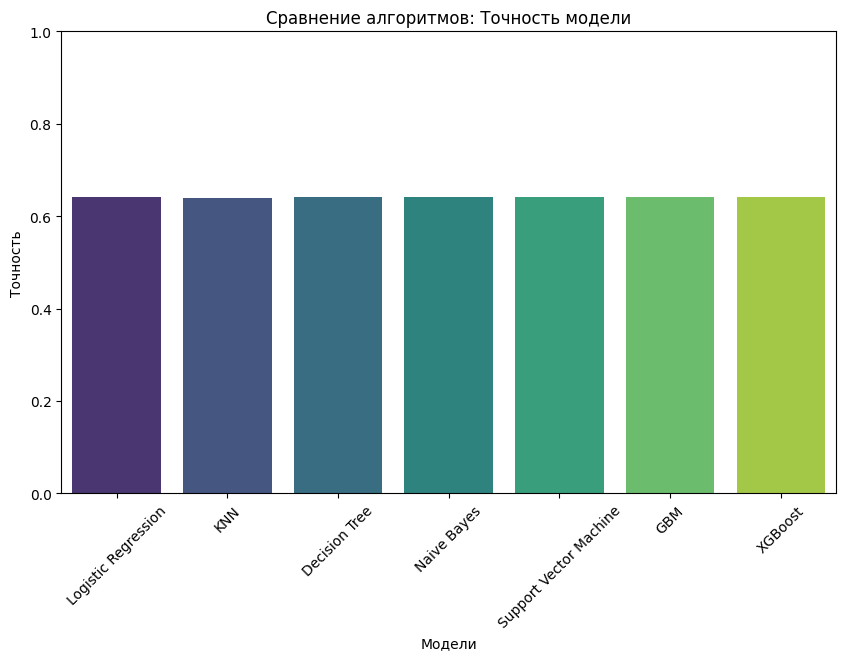

In [42]:
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier(n_neighbors=16)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Support Vector Machine', SVC()),
    ('GBM', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier(eval_metric='mlogloss'))
]

# Prepare lists to store results and names
results = []
names = []

# Evaluate each model in turn
for name, model in models:
    # Train the model using training data (SMOTE for handling imbalance)
    model.fit(X_train_rfe, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_rfe)

    # Accuracy score
    accuracy = model.score(X_test_rfe, y_test)
    results.append(accuracy)
    names.append(name)
    print(f"{name}: Accuracy: {accuracy:.3f}")
    
    # Classification report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=['Healthy', 'Heart Attack'], 
                yticklabels=['Healthy', 'Heart Attack'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Bar plot for algorithm comparison (accuracies of models)
plt.figure(figsize=(10, 6))
sns.barplot(x=names, y=results, palette='viridis')
plt.title('Сравнение алгоритмов: Точность модели')
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.ylim(0, 1)  # Limiting y-axis from 0 to 1 for accuracy percentage
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()

Logistic Regression: Accuracy: 0.530
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.64      0.61      0.62      1125
           1       0.36      0.39      0.37       628

    accuracy                           0.53      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.54      0.53      0.53      1753




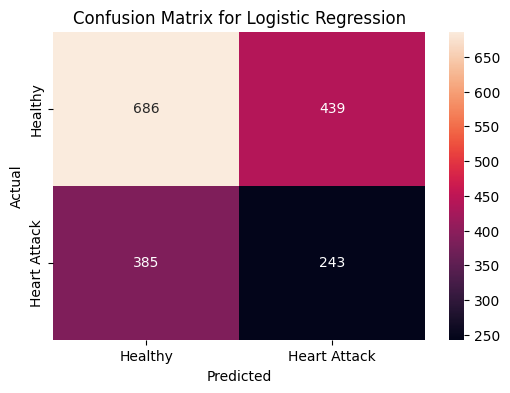

KNN: Accuracy: 0.512
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.64      0.54      0.59      1125
           1       0.36      0.45      0.40       628

    accuracy                           0.51      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.51      0.52      1753




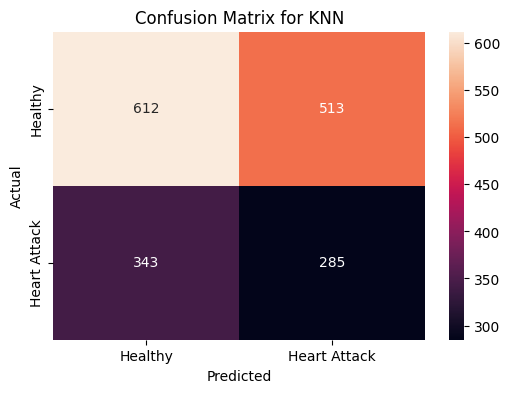

Decision Tree: Accuracy: 0.532
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61      1125
           1       0.37      0.46      0.41       628

    accuracy                           0.53      1753
   macro avg       0.51      0.52      0.51      1753
weighted avg       0.55      0.53      0.54      1753




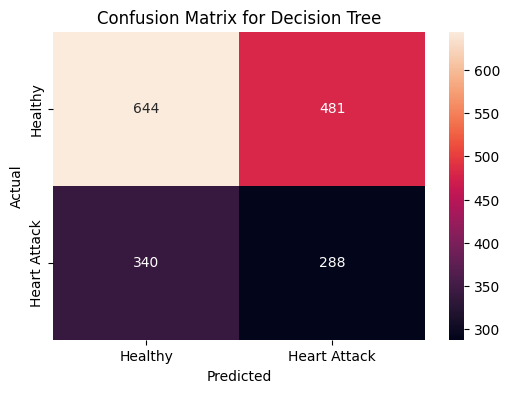

Naive Bayes: Accuracy: 0.475
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.64      0.41      0.50      1125
           1       0.36      0.60      0.45       628

    accuracy                           0.48      1753
   macro avg       0.50      0.50      0.47      1753
weighted avg       0.54      0.48      0.48      1753




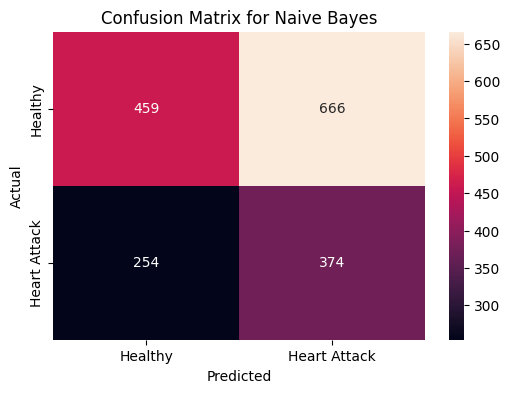

Support Vector Machine: Accuracy: 0.544
Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      1125
           1       0.35      0.31      0.32       628

    accuracy                           0.54      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.54      0.54      1753




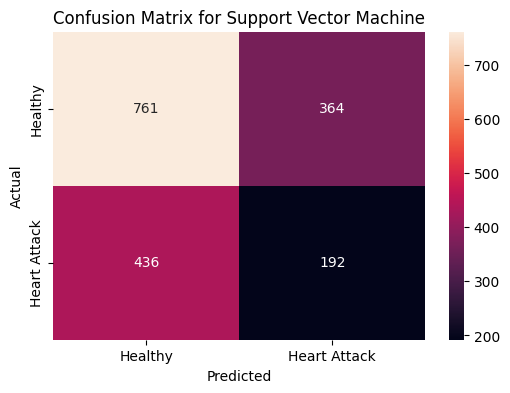

GBM: Accuracy: 0.547
Classification Report for GBM:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65      1125
           1       0.36      0.33      0.35       628

    accuracy                           0.55      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.54      0.55      0.54      1753




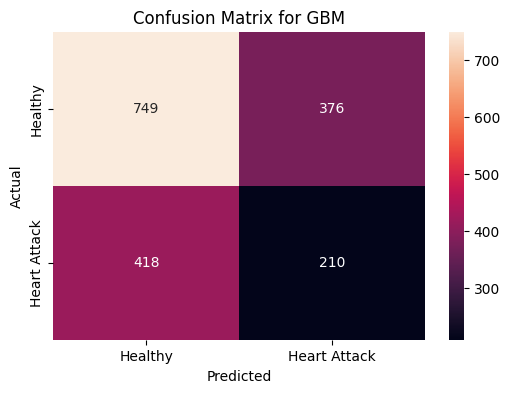

XGBoost: Accuracy: 0.569
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67      1125
           1       0.39      0.35      0.37       628

    accuracy                           0.57      1753
   macro avg       0.52      0.52      0.52      1753
weighted avg       0.56      0.57      0.56      1753




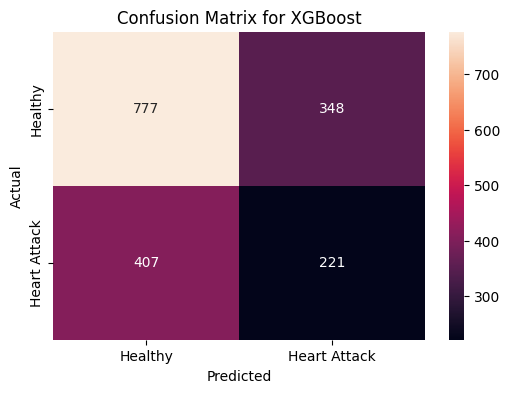

/tmp/ipykernel_8886/1540511332.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=results, palette='viridis')


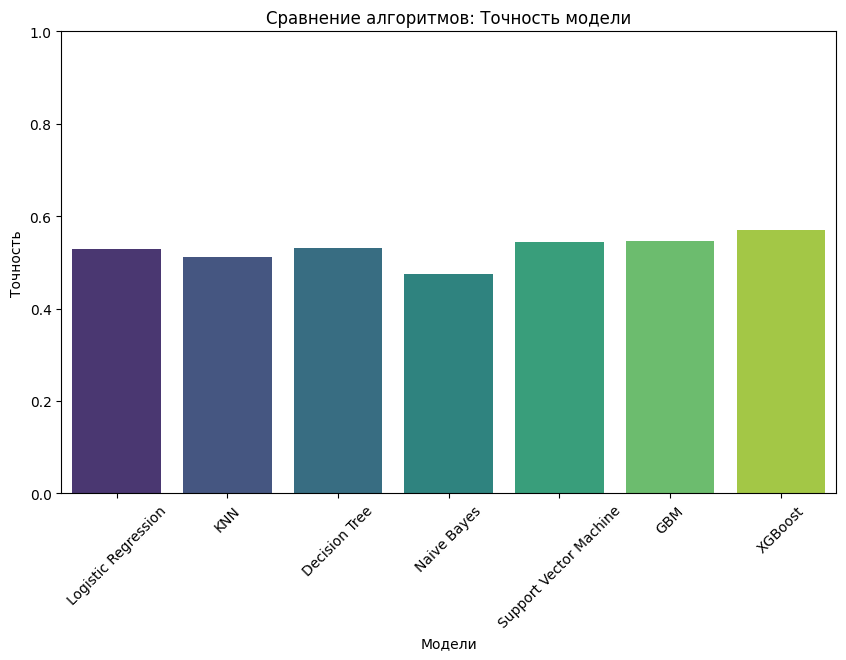

In [15]:
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Support Vector Machine', SVC()),
    ('GBM', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier(eval_metric='mlogloss'))
]

# Prepare lists to store results and names
results = []
names = []

# Evaluate each model in turn
for name, model in models:
    # Train the model using training data (SMOTE for handling imbalance)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Accuracy score
    accuracy = model.score(X_test, y_test)
    results.append(accuracy)
    names.append(name)
    print(f"{name}: Accuracy: {accuracy:.3f}")
    
    # Classification report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=['Healthy', 'Heart Attack'], 
                yticklabels=['Healthy', 'Heart Attack'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Bar plot for algorithm comparison (accuracies of models)
plt.figure(figsize=(10, 6))
sns.barplot(x=names, y=results, palette='viridis')
plt.title('Сравнение алгоритмов: Точность модели')
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.ylim(0, 1)  # Limiting y-axis from 0 to 1 for accuracy percentage
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()